# Q-Trainer for QAOA

In [1]:
import qtrainer
import networkx as nx
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Define a graph

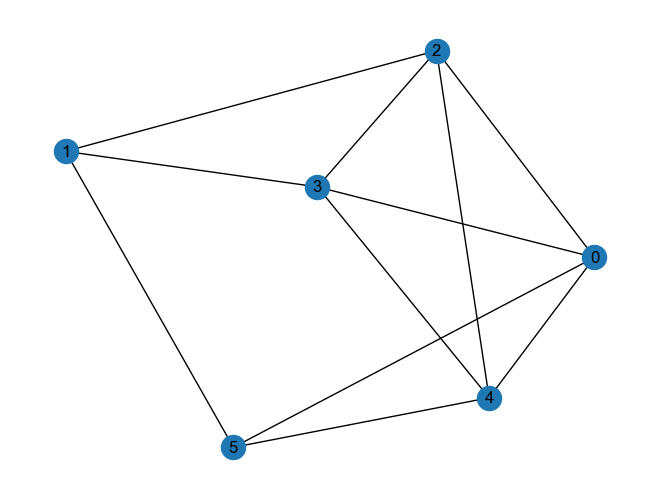

In [2]:
n_nodes = 6
p = 0.5  # probability of an edge
seed = 1967

g = nx.erdos_renyi_graph(n_nodes, p=p, seed=seed)
positions = nx.spring_layout(g, seed=seed)
#draw the graph with the node index as the node label
nx.draw(g, pos=positions, with_labels=True)


## Q-Trainer's QAOA Circuit class
Available QAOA Tasks:
- `maxcut`: Maximum Cut
- `max_clique`: Maximum Clique
- `max_independent_set`: Maximum Independent Set
- `max_weight_cycle`: Maximum Weighted Cycle
- `min_vertex_cover`: Minimum Vertex Cover

In [3]:
task = "maxcut"
depth = 2
circuit = qtrainer.circuits.QAOACircuit(graph=g, task=task, depth=depth, seed=0)

## Noise Model
Depolarization noise on all gates

In [4]:
noise_gate = qml.DepolarizingChannel
noise_strength = 0.1
noise_fn = qml.transforms.insert(noise_gate, noise_strength, position="all")

## Trainer
+ `circuit`: Q-Trainer Circuit class
+ `device_name`: Pennylane-stype device name. (For noised simulation, use `default.mixed`/`cirq.mixedsimulator`/`braket_dm`.)
+ `optimizer`: could be `Adam`, `SGD`, `ShotAdaptive`, `SPSA`, etc.
+ `noise_fn`: preset noise function
+ `error_mitigation_method`: Quantum error mitigation method. Currently, only Zero-Noise Zxtrapolation (`zne`) is supported
+ `n_steps`: number of optimization steps

In [5]:
train_config = dict(
    device_name = 'default.mixed',
    optimizer = 'Adam',
    optimizer_config={'stepsize': 1},
    n_steps = 100,
    noise_fn = noise_fn,
    eval_freq = 5
)


**Trainer with Zero-Noise Extrapolation**

In [6]:
trainer_zne = qtrainer.Trainer(circuit, 
                            error_mitigation_method='zne',
                            **train_config)

**Start training!**

In [7]:
log = trainer_zne.train()

Train:   0%|          | 0/100 [00:00<?, ?it/s]

**For comparison, we train a circuit without error mitigation as a baseline.**

In [8]:
circuit_base = qtrainer.circuits.QAOACircuit(graph=g, task=task, depth=depth, seed=0)
trainer_base = qtrainer.Trainer(circuit_base, 
                                        error_mitigation_method=None,
                                        **train_config
                                        )

In [9]:
log_base = trainer_base.train()

Train:   0%|          | 0/100 [00:00<?, ?it/s]

## Evaluation

In [10]:
def cut_size(measurement, graph):
    S = np.argwhere(measurement == 1).flatten()
    T = np.argwhere(measurement == 0).flatten()
    return nx.cut_size(graph, S, T)

def est_measurement_prob(trainer,shots=10000):
    shots = 10000000
    wires = trainer.n_qubits
    s = trainer.sample_measurement(shots=shots).T.numpy()
    s = (1 - s) / 2
    s = map(tuple, s)
    counts = Counter(s)
    indx = np.ndindex(*[2] * wires)
    probs = {p: counts.get(p, 0) / shots for p in indx}
    return probs

In [11]:
import seaborn as sns
sns.set_style("white")

In [12]:
def plot_maxcut_results(all_probs:dict,cuts,n_qubits:int,title=None):
    COLORS = [ 'tab:orange','tab:green','red', 'blue', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    STYLES = ['-', '--', '-.', ':']

    probs = list(all_probs.values())[0]
    labels = np.array(["{0:{fill}6b}".format(i, fill='0') for i in range(len(probs))])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    normalized_cuts = np.array(list(cuts.values()))
    order = np.argsort(normalized_cuts).flatten()
    for i,(k,v) in enumerate(all_probs.items()):
        ax.plot(np.arange(2 ** n_qubits), np.array(list(v.values()))[order],label=k,color=COLORS[i],linestyle=STYLES[i%len(STYLES)])
    ax.set_xlabel("Sample", size=20)
    ax.set_ylabel("Probability", size=20)

    maxcut_index = np.argwhere(normalized_cuts==normalized_cuts.max()).flatten()


    colors = np.array(['red' if i in maxcut_index else 'black' for i in range(len(probs))])
    ax.set_xticks(np.arange(len(probs)), labels[order], rotation='vertical', size=12, color='black')
    colors = colors[order]
    for i,tick in enumerate(ax.get_xticklabels()):
        tick.set_color(colors[i])
    # ax2 bar plot on the cut size
    ax2 = ax.twinx()
    ax2.bar(np.arange(2 ** n_qubits), normalized_cuts[order], alpha=0.1, color='black',label='Cut Size')
    ax2.set_ylabel("Cut Size", size=20)
    ax2.set_ylim(0,1.1*max(normalized_cuts))
    ax2.set_yticklabels([f'{i:.2f}' for i in ax2.get_yticks()],size=12)

    ax.set_xlim(0,2 ** n_qubits-0.5)
    ax.set_title(title,size=20)
    ax.legend(loc='upper left',prop={'size': 15})
    ax2.legend(loc='upper right',prop={'size': 15})
    fig = plt.gcf()
    fig.set_size_inches(16, 8)
    return fig

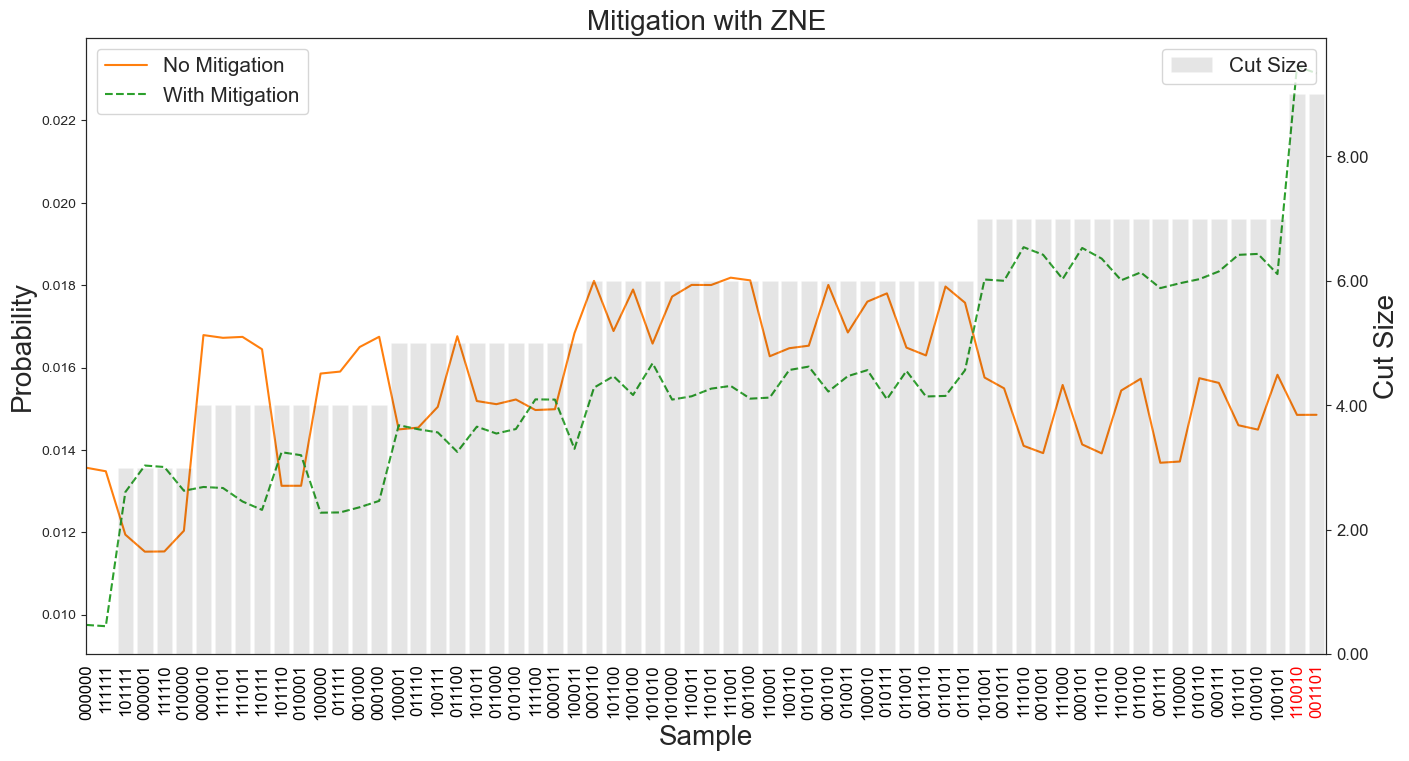

In [13]:
probs_zne = est_measurement_prob(trainer_zne)
probs_base = est_measurement_prob(trainer_base)
cuts = {k: cut_size(np.array(k), g) for k in probs_zne.keys()}
all_probs = {'No Mitigation':probs_base,'With Mitigation':probs_zne}

fig_zne = plot_maxcut_results(all_probs, cuts, n_qubits=n_nodes, title='Mitigation with ZNE')
fig_zne.set_facecolor('white')
